## Upsell 모델 remodeling

### 목적
- 최신 데이터 반영
 
### 모델링
- 기존과 동일한 feature, preprocessing
- 맞춤형 요금제 회선은 제외
    - bas_ofr_data_gb_qty 값이 0.0001로 다른 회선과 다른 특성을 지님 -> 모델링 시 

In [1]:
import lightgbm as lgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive


from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data/'

In [3]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [4]:
def next_month(ym):
    next_month = datetime.strptime(ym, '%Y%m') + relativedelta(months=1)
    return datetime.strftime(next_month, '%Y%m')

### load data

In [5]:
df_mart06 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201906.pkl'))

df_mart07 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201907.pkl'))

In [6]:
df_mart06.shape, df_mart07.shape

((18620965, 81), (18612165, 81))

## 맞춤형 요금제 고객 제거

In [7]:
filter_sql = """
select svc_mgmt_num, ym
from comm.user_profile_pivot_monthly
where ym between '201906' and '201908'
and filter_fee_prod = 'Y'
"""

In [8]:
df_filter = load_from_hive(hive_connection('dmig'), filter_sql)

2019-09-05 15:49:37,100 - YE_HIVE - INFO - ...tmp_db name = tmp_20190905_15_49_37_7999066ccd0c4571415e58a256138449d024c395
2019-09-05 15:49:37,103 - YE_HIVE - INFO - Start creating table
2019-09-05 15:49:37,104 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190905_15_49_37_7999066ccd0c4571415e58a256138449d024c395
2019-09-05 15:49:37,156 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190905_15_49_37_7999066ccd0c4571415e58a256138449d024c395' is done
2019-09-05 15:52:34,431 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190905_15_49_37_7999066ccd0c4571415e58a256138449d024c395 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select svc_mgmt_num, ym
from comm.user_profile_pivot_monthly
where ym between '201906' and '201908'
and filter_fee_prod = 'Y'
' is done
2019-09-05 15:52:34,685 -

In [9]:
df_filter.shape

(4493480, 2)

In [10]:
df_filter.to_pickle(os.path.join(DATA_PATH, 'filter.pkl'))

In [11]:
df_filter['ym'].value_counts()

201906    1512866
201907    1498620
201908    1481994
Name: ym, dtype: int64

In [12]:
filter06 = list(df_filter[df_filter['ym']=='201906'].svc_mgmt_num)
filter07 = list(df_filter[df_filter['ym']=='201907'].svc_mgmt_num)
filter08 = list(df_filter[df_filter['ym']=='201908'].svc_mgmt_num)

In [13]:
df_mart06_new = df_mart06[~df_mart06['svc_mgmt_num'].isin(filter06)]
df_mart07_new = df_mart07[~df_mart07['svc_mgmt_num'].isin(filter07)]

In [14]:
df_mart06.shape, df_mart06_new.shape, df_mart07.shape, df_mart07_new.shape

((18620965, 81), (17134299, 81), (18612165, 81), (17152632, 81))

In [15]:
# make train data
result = make_train_data(df_mart07_new)

trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']

val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

feature_cols = list(x_trn.columns)

lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

make_train_data +++
label/sample:  0.2
sample/total:  0.1322823226196423
make_data_for_modeling---


In [16]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'num_threads': 40,
}

In [17]:
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=5000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.771883	valid_1's auc: 0.772422
[100]	training's auc: 0.781656	valid_1's auc: 0.782022
[150]	training's auc: 0.786196	valid_1's auc: 0.786198
[200]	training's auc: 0.789151	valid_1's auc: 0.788716
[250]	training's auc: 0.79117	valid_1's auc: 0.790324
[300]	training's auc: 0.792657	valid_1's auc: 0.791404
[350]	training's auc: 0.793759	valid_1's auc: 0.792107
[400]	training's auc: 0.794818	valid_1's auc: 0.792727
[450]	training's auc: 0.79566	valid_1's auc: 0.793125
[500]	training's auc: 0.796445	valid_1's auc: 0.79349
[550]	training's auc: 0.797197	valid_1's auc: 0.79378
[600]	training's auc: 0.797975	valid_1's auc: 0.794136
[650]	training's auc: 0.798692	valid_1's auc: 0.794394
[700]	training's auc: 0.799355	valid_1's auc: 0.794612
[750]	training's auc: 0.800004	valid_1's auc: 0.794804
[800]	training's auc: 0.800603	valid_1's auc: 0.79496
[850]	training's auc: 0.801214	valid_1's auc: 0.795128
[900]	tr

In [18]:
test_result = make_test_data(df_mart06_new)
x_test = test_result['x']
y_test = test_result['y']

        acc    recall  precision  f1_score       auc
0  0.654654  0.746465   0.048273  0.090682  0.766233
         pred: 1   pred: 0
true: 1   295050    100213
true: 0  5817045  10921991


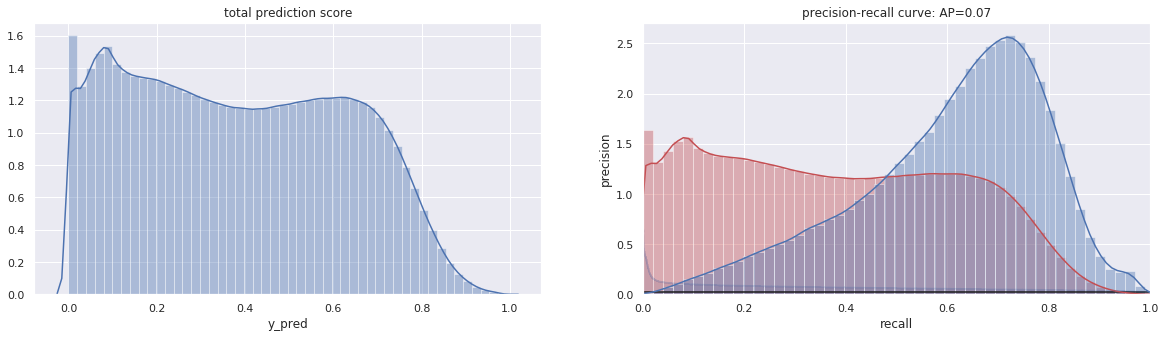

In [19]:
eval_result = evaluate(x_test[feature_cols], y_test.label.values, clf, clf_name='lgb')

In [20]:
from item_reco_test_binary_post import OfflineTest4Binary

In [21]:
ot4b = OfflineTest4Binary(
    reco_type='upsell',
    test_ym='201906',
    model=clf,
    model_name='dominic_lgbm_07_20190905',
    feature_cols=clf.feature_name()
)

init +++
reco_type:  upsell
prod_id:  RC00000001
prod_nm:  요금제업셀가망
test_ym:  201906
model_name:  dominic_lgbm_07_20190905
feature_cols:  ['sex_cd', 'age', 'svc_gr', 'mng_nice_cb_scr', 'mng_nice_cb_grd', 'svc_scrb_period', 'last_equip_period', 'bas_fee_amt', 'bas_ofr_data_gb', 'eqp_out_prc', 'allot_prn_amt', 'pmth_inv_bamt', 'family_yn', 'family_small_yn', 'twld_visit_cnt_bf_m0', 'twld_visit_cnt_bf_m1', 'twld_visit_cnt_bf_m2', 'avg_twld_visit_cnt', 'twld_fee_visit_cnt_bf_m0', 'twld_fee_visit_cnt_bf_m1', 'twld_fee_visit_cnt_bf_m2', 'avg_twld_fee_visit_cnt', 'ansim_yn', 'ref_data_usage_in_gb_bf_m0', 'ref_data_usage_in_gb_bf_m1', 'ref_data_usage_in_gb_bf_m2', 'data_usage_in_gb_bf_m0', 'data_usage_in_gb_bf_m1', 'data_usage_in_gb_bf_m2', 'avg_data_usage_in_gb', 'overage_bf0', 'overage_bf1', 'overage_bf2', 'copn_data_u1_yn_bf_m0', 'copn_data_u1_yn_bf_m1', 'copn_data_u1_yn_bf_m2', 'data_gift_send_yn_bf_m0', 'data_gift_send_yn_bf_m1', 'data_gift_send_yn_bf_m2', 'data_gift_recv_yn_bf_m0', 'data_

In [22]:
ot4b.one_shot(df_mart06)

one_shot +++
submit_to_item_reco_test +++
load_to_comm_table +++
load to dumbo table +++
2019-09-05 16:09:22,020 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_test_upsell (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, ym string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-09-05 16:09:22,038 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-09-05 16:10:59,844 - YE_HIVE - INFO - Loading data to HDFS... 
2019-09-05 16:11:16,263 - YE_HIVE - INFO - Loading to table dumbo.item_reco_test_upsell is done
insert to comm table +++
2019-09-05 16:14:04,021 - YE_HIVE - INFO - Query '
            INSERT  OVERWRITE TABLE comm.item_reco_test PARTITION (reco_type, model, ym)
            SELECT  *
            FROM    dumbo.item_reco_test_upsell
        ' is done
drop dumbo table +++
2019-09-05 16:14:04,817 - YE_HIVE - INFO - Query 'dr

## model 해석

In [103]:
pd.DataFrame({'feature': clf.feature_name(), 'importance': clf.feature_importance()}).sort_values('importance', ascending=False).head(50)

feature  importance
6            last_equip_period        5617
1                          age        4746
5              svc_scrb_period        3240
45            avg_chg_duration        3163
3              mng_nice_cb_scr        3024
53            data_usage_ratio        2975
7                  bas_fee_amt        2910
44     avg_subscription_period        2832
54  bf_m6_data_usage_ratio_avg        2708
46             real_arpu_bf_m1        2625
10               allot_prn_amt        2295
8              bas_ofr_data_gb        2223
48             real_arpu_bf_m3        2212
26      data_usage_in_gb_bf_m0        2127
47             real_arpu_bf_m2        1980
11               pmth_inv_bamt        1970
27      data_usage_in_gb_bf_m1        1898
28      data_usage_in_gb_bf_m2        1883
49               real_avg_arpu        1767
29        avg_data_usage_in_gb        1503
51  bf_m6_sum_data_usage_in_gb        1479
52  bf_m6_avg_data_usage_in_gb        1234
43             avg_mbr_use_cnt        1196
78                     channel         719
57           copn_left_cnt_bf0         633
30                 overage_bf0         599
17          avg_twld_visit_cnt         595
4              mng_nice_cb_grd         546
12                   family_yn         534
59           copn_left_cnt_bf2         506
16        twld_visit_cnt_bf_m2         478
32                 overage_bf2         433
50           bf_m3_fee_chg_cnt         426
55   bf_m6_data_over_usage_cnt         421
31                 overage_bf1         421
0                       sex_cd         405
69          mth_cnsl_cnt_bf_m0         400
2                       svc_gr         372
58           copn_left_cnt_bf1         359
71          mth_cnsl_cnt_bf_m2         325
15        twld_visit_cnt_bf_m1         320
70          mth_cnsl_cnt_bf_m1         303
25  ref_data_usage_in_gb_bf_m2         302
24  ref_data_usage_in_gb_bf_m1         278
75    simpl_ref_cnsl_cnt_bf_m0         255
77    simpl_ref_cnsl_cnt_bf_m2         250
76    simpl_ref_cnsl_cnt_bf_m1         222
13             family_small_yn         219
22                    ansim_yn         215
42                  sec_dev_yn         208

- top 20 살펴보기
- label 별 분포

In [96]:
top20_cols = list(pd.DataFrame({'feature': clf.feature_name(), 'importance': clf.feature_importance()}).sort_values('importance', ascending=False).head(20).feature)

In [95]:
from eda_tools import numeric_eda_plot, categorical_eda_plot

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 100000, 1: 100000}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



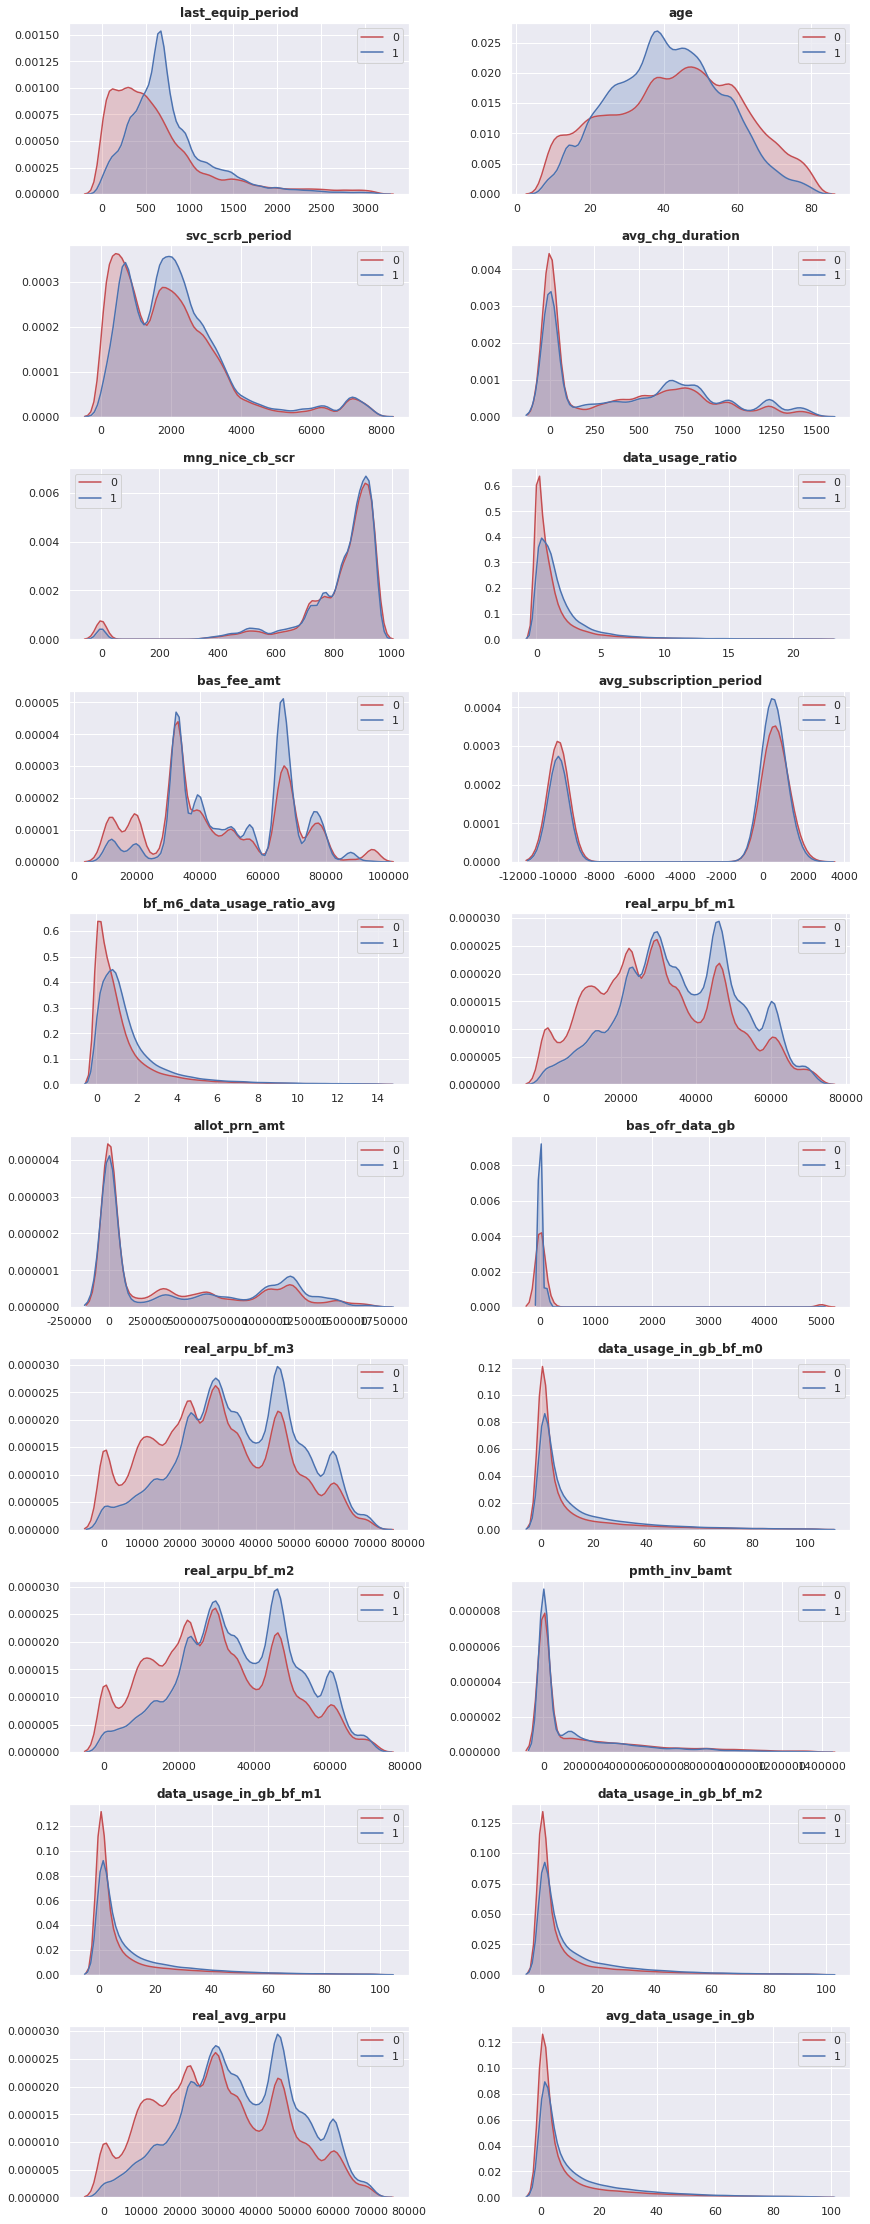

In [99]:
numeric_eda_plot(df_mart07_new, top20_cols, 'label', n_samples=100000)

In [113]:
zero_dict = {}

array(['1409061400', '7007312421', '7017241645', ..., '7305016394',
       '7305019009', '7305020035'], dtype=object)

In [126]:
for col in top20_cols:
    if col in ['age', 'avg_chg_duration', 'avg_subscription_period', 'allot_prn_amt', 'pmth_inv_bamt']:
        continue
    print('='*50)
    print('col: ', col)
    print('label ratio: ', df_mart07_new[df_mart07_new[col]==0].label.sum()/df_mart07_new[df_mart07_new[col]==0].shape[0])
    print('cnt: ', df_mart07_new[df_mart07_new[col]==0].shape[0])
    
    zero_dict[col] = list(df_mart07_new[df_mart07_new[col]==0].svc_mgmt_num.values)

col:  last_equip_period
label ratio:  0.007892997394922042
cnt:  25719
col:  svc_scrb_period
label ratio:  0.011572114027660174
cnt:  10629
col:  mng_nice_cb_scr
label ratio:  0.009375046688479525
cnt:  133866
col:  data_usage_ratio
label ratio:  0.009066056228212653
cnt:  2143159
col:  bas_fee_amt
label ratio:  0.017241379310344827
cnt:  58
col:  bf_m6_data_usage_ratio_avg
label ratio:  0.008479918731110207
cnt:  1943179
col:  real_arpu_bf_m1
label ratio:  0.005146029413803141
cnt:  577144
col:  bas_ofr_data_gb
label ratio:  nan
cnt:  0
col:  real_arpu_bf_m3
label ratio:  0.0058829192824963236
cnt:  903633
col:  data_usage_in_gb_bf_m0
label ratio:  0.009066056228212653
cnt:  2143159
col:  real_arpu_bf_m2
label ratio:  0.00567439301189903
cnt:  726950
col:  data_usage_in_gb_bf_m1
label ratio:  0.009263414031843739
cnt:  2324413
col:  data_usage_in_gb_bf_m2
label ratio:  0.00893543121833965
cnt:  2509448
col:  real_avg_arpu
label ratio:  0.004809306276580552
cnt:  539163
col:  avg_data_

In [119]:
zero_dict.keys()

dict_keys(['last_equip_period', 'svc_scrb_period', 'mng_nice_cb_scr', 'data_usage_ratio', 'bas_fee_amt', 'bf_m6_data_usage_ratio_avg', 'real_arpu_bf_m1', 'bas_ofr_data_gb', 'real_arpu_bf_m3', 'data_usage_in_gb_bf_m0', 'real_arpu_bf_m2', 'data_usage_in_gb_bf_m1', 'data_usage_in_gb_bf_m2', 'real_avg_arpu', 'avg_data_usage_in_gb'])

In [134]:
t = ['svc_mgmt_num', 'label'] + [c for c in zero_dict.keys() if 'data' in c] + [c for c in zero_dict.keys() if 'arpu' in c] + ['last_equip_period', 'svc_scrb_period', 'mng_nice_cb_scr']

In [128]:
[c for c in zero_dict.keys() if 'arpu' in c]

['real_arpu_bf_m1', 'real_arpu_bf_m3', 'real_arpu_bf_m2', 'real_avg_arpu']

In [137]:
df_mart07_new[df_mart07_new['data_usage_in_gb_bf_m2']==0][t].head(50)

svc_mgmt_num  label  data_usage_ratio  bf_m6_data_usage_ratio_avg  \
4     1002243510      0          0.000000                    0.000000   
13    1007234202      0          2.125788                    1.793643   
20    1013934510      0          0.030462                    0.748705   
41    1028208300      0          0.000000                    0.000000   
43    1030209303      0          0.000000                    0.000000   
45    1032341110      0          0.000000                    0.000000   
48    1034929604      0          0.000000                    0.000000   
55    1042579412      0          0.000000                    0.000000   
61    1045578703      0          0.000000                    0.000000   
64    1045840603      0          0.000000                    0.000000   
70    1048014708      0          0.000000                    0.000000   
71    1049350908      0          0.095468                    0.108943   
74    1050005101      0          0.000028                    0.000000   
105   1080368303      0          0.038308                    0.057586   
122   1093614005      0          0.000000                    0.000000   
123   1093921409      0          0.000000                    0.000000   
125   1094090900      0          0.000000                    0.000000   
143   1108867600      0          0.000000                    0.014885   
144   1109427106      0          0.000000                    0.184798   
148   1114552010      0          0.015658                    0.136861   
158   1123212308      0          0.000000                    0.000000   
160   1123701010      0          0.000000                    0.000000   
181   1143948104      0          0.000000                    0.000000   
186   1150035020      0          0.004253                    0.000709   
222   1175000109      0          1.268327                    0.542391   
224   1175302202      0          0.000000                    0.000000   
240   1194129507      0          0.000000                    0.000000   
249   1202952409      0          0.000000                    0.000000   
264   1218333800      0          0.309944                    0.000000   
288   1231939111      0          0.000000                    0.000000   
291   1237667309      0          0.000484                    0.000641   
295   1242834901      0          2.951622                    0.000000   
302   1250098703      0          0.000000                    0.000000   
310   1253074807      0          0.000000                    0.000000   
322   1261290511      0          0.000000                    0.000000   
323   1261418610      0          0.000000                    0.000000   
334   1269885708      0          0.000000                    0.000000   
335   1270175908      0          0.000000                    0.000000   
337   1271845117      0          0.000000                    0.000000   
350   1279961205      0         17.401698                   14.753853   
358   1288056202      0          0.009183                    3.749676   
359   1288355305      0          0.007782                    0.523211   
364   1291944813      0          0.000000                    0.000000   
377   1309688208      0          0.000000                    0.000000   
380   1312388413      0          0.000000                    0.000000   
387   1314828302      0          0.000000                    0.000000   
394   1324508900      0          1.825176                    1.690964   
412   1340110400      0          0.000000                    0.000000   
418   1346243205      0          0.000000                    0.000000   
424   1350085209      0          0.000037                    0.000000   

     bas_ofr_data_gb  data_usage_in_gb_bf_m0  data_usage_in_gb_bf_m1  \
4           0.000100                0.000000                0.000000   
13          4.000000                8.503153                1.607647   
20        100.000000                3.046155                1.61

In [127]:
a = 'data_usage_ratio'
b = 'bf_m6_data_usage_ratio_avg'

print(len(zero_dict[a]))
print(len(zero_dict[b]))

print(len([c for c in zero_dict[a] if c not in zero_dict[b]]))

2143159
1943179


KeyboardInterrupt: 

In [ ]:
a = 'data_usage_in_gb_bf_m1'
b = 'data_usage_in_gb_bf_m2'

print(len(zero_dict[a]))
print(len(zero_dict[b]))

print(len([c for c in zero_dict[a] if c not in zero_dict[b]]))

## shap value

In [30]:
from shap_tools import ShapModule

In [31]:
sm = ShapModule(df_mart07_new, clf, feature_cols, 'svc_mgmt_num', 'label')

sm.calculate_shap_value()

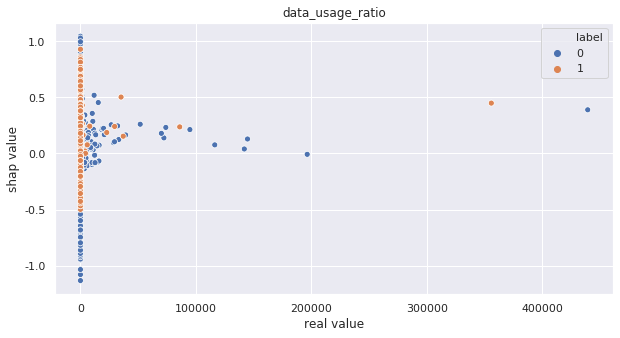

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



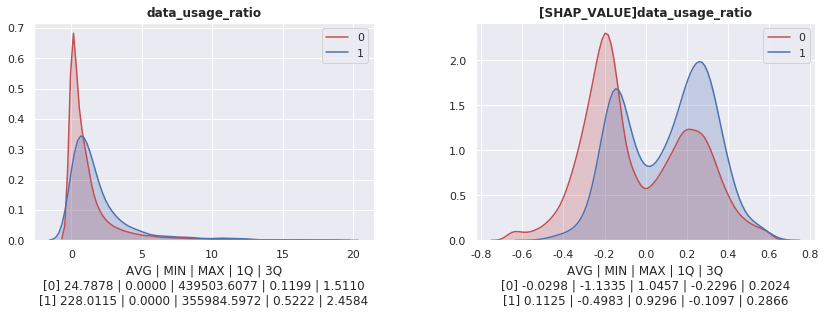

In [74]:
sm.real_vs_shap_scatter_plot('data_usage_ratio')

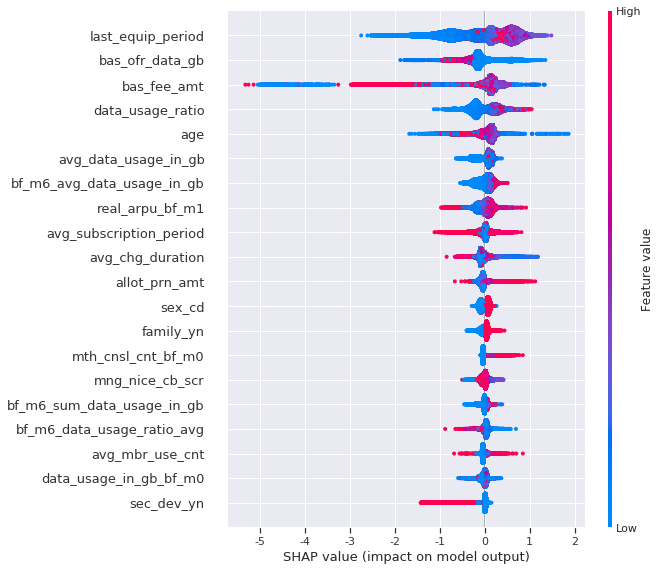

In [33]:
sm.summary_plot(max_display=20)

In [ ]:
1002243510	1	46	2	720	6	7596	1498	59400	0.0001	...	0	0	0	0	0	0	0	0	3	0
41	1028208300	1	44	1	739	6	8095	2244	12100	0.0001	...	0	3	0	0	0	0	0	3	2	0
43	1030209303	1	71	1	870	2	8502	213	9900	0.0001	...	0	0	0	0	0	0	0	0	3	0
45	1032341110	0	30	1	874	2	6792	6792	15400	0.0001	...	0	0	0	0	0	0	0	0	0	0
48	1034929604

In [56]:
svc_mgmt_num = '1032341110'
single_shap_value = sm.explainer.shap_values(sm.df[sm.feature_cols].loc[[svc_mgmt_num], :])
shap.force_plot(sm.explainer.expected_value, single_shap_value, 
                df_mart07_new[df_mart07_new['svc_mgmt_num']==svc_mgmt_num][sm.feature_cols], sm.feature_cols, out_names=str(svc_mgmt_num))

In [57]:
df_mart07_new[df_mart07_new['bas_ofr_data_gb']==0.0001].label.sum()/df_mart07_new[df_mart07_new['bas_ofr_data_gb']==0.0001].shape[0]

0.014331327871220443

In [58]:
df_mart07_new.label.sum()/df_mart07_new.shape[0]

0.026456464523928455

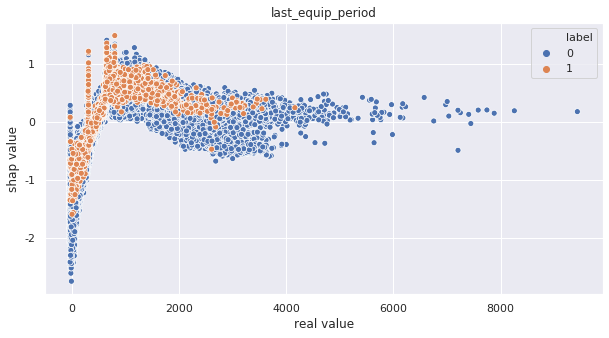

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



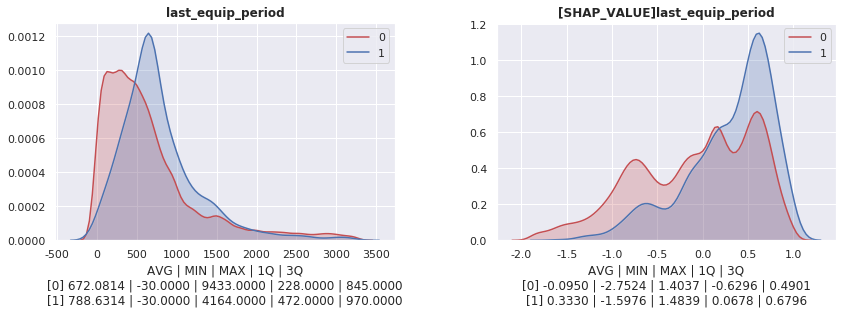

In [35]:
sm.real_vs_shap_scatter_plot('last_equip_period')

In [68]:
df_mart06.columns

Index(['svc_mgmt_num', 'sex_cd', 'age', 'svc_gr', 'mng_nice_cb_scr',
       'mng_nice_cb_grd', 'svc_scrb_period', 'last_equip_period',
       'bas_fee_amt', 'bas_ofr_data_gb', 'eqp_out_prc', 'allot_prn_amt',
       'pmth_inv_bamt', 'family_yn', 'family_small_yn', 'twld_visit_cnt_bf_m0',
       'twld_visit_cnt_bf_m1', 'twld_visit_cnt_bf_m2', 'avg_twld_visit_cnt',
       'twld_fee_visit_cnt_bf_m0', 'twld_fee_visit_cnt_bf_m1',
       'twld_fee_visit_cnt_bf_m2', 'avg_twld_fee_visit_cnt', 'ansim_yn',
       'ref_data_usage_in_gb_bf_m0', 'ref_data_usage_in_gb_bf_m1',
       'ref_data_usage_in_gb_bf_m2', 'data_usage_in_gb_bf_m0',
       'data_usage_in_gb_bf_m1', 'data_usage_in_gb_bf_m2',
       'avg_data_usage_in_gb', 'overage_bf0', 'overage_bf1', 'overage_bf2',
       'copn_data_u1_yn_bf_m0', 'copn_data_u1_yn_bf_m1',
       'copn_data_u1_yn_bf_m2', 'data_gift_send_yn_bf_m0',
       'data_gift_send_yn_bf_m1', 'data_gift_send_yn_bf_m2',
       'data_gift_recv_yn_bf_m0', 'data_gift_recv_yn_bf_m

In [ ]:
df_mart06['usage_data']

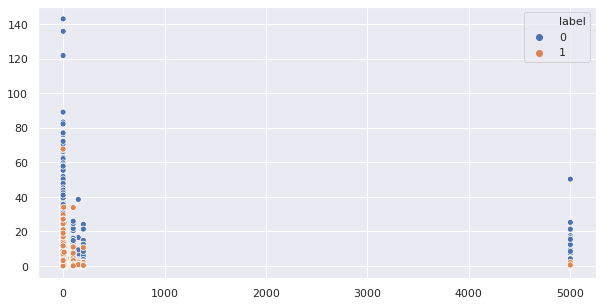

In [70]:
sm.real_value_scatter_plot('bas_ofr_data_gb', 'bf_m6_data_usage_ratio_avg')

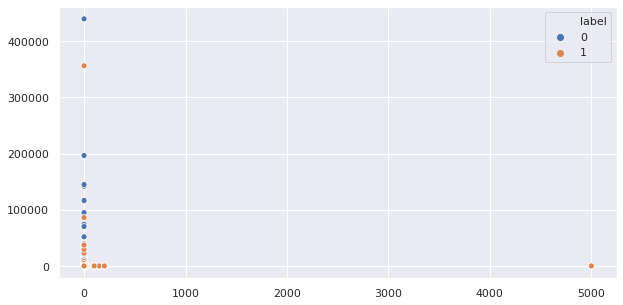

In [69]:
sm.real_value_scatter_plot('bas_ofr_data_gb', 'data_usage_ratio')

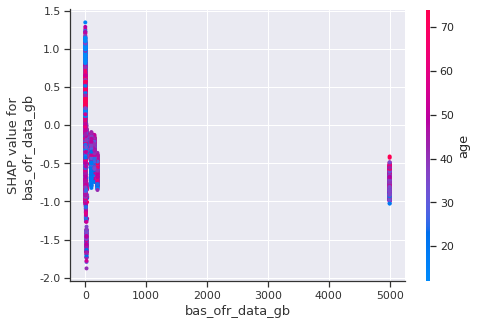

In [60]:
sm.dependence_plot('bas_ofr_data_gb')

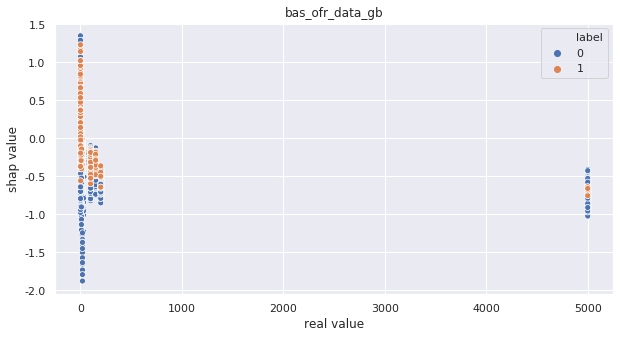

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



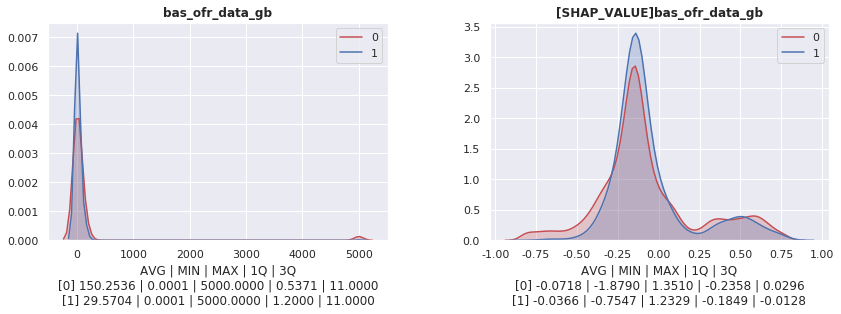

In [36]:
sm.real_vs_shap_scatter_plot('bas_ofr_data_gb')

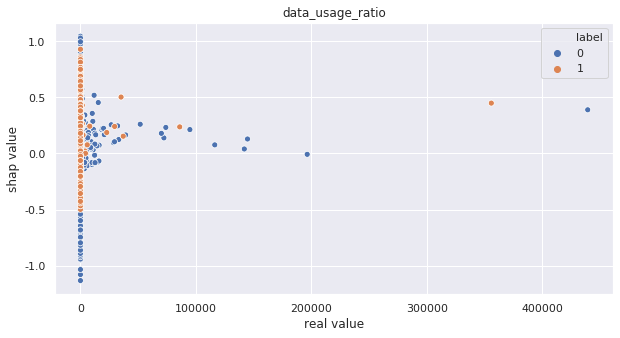

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



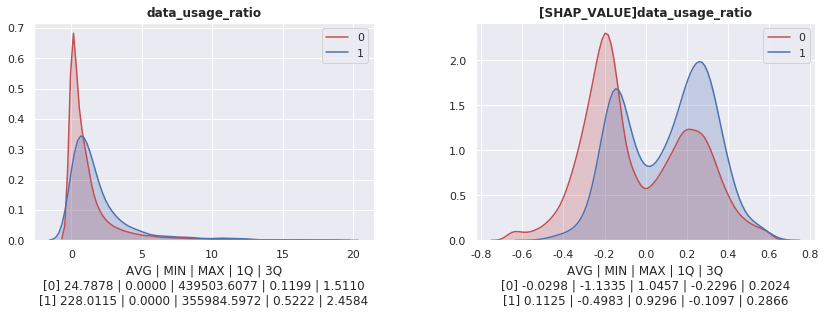

In [61]:
sm.real_vs_shap_scatter_plot('data_usage_ratio')

In [45]:
df_mart07_new[df_mart07_new['bas_ofr_data_gb']==0.0001].shape

(1190748, 81)

In [46]:
df_mart07[df_mart07['bas_ofr_data_gb']==0.0001].shape

(2143478, 81)

In [47]:
df_mart07_new[df_mart07_new['bas_ofr_data_gb']==0.0001].head()

svc_mgmt_num  sex_cd  age  svc_gr  mng_nice_cb_scr  mng_nice_cb_grd  \
4    1002243510       1   46       2              720                6   
41   1028208300       1   44       1              739                6   
43   1030209303       1   71       1              870                2   
45   1032341110       0   30       1              874                2   
48   1034929604       1   58       1              827                4   

    svc_scrb_period  last_equip_period  bas_fee_amt  bas_ofr_data_gb  ...  \
4              7596               1498        59400           0.0001  ...   
41             8095               2244        12100           0.0001  ...   
43             8502                213         9900           0.0001  ...   
45             6792               6792        15400           0.0001  ...   
48             7049               1466        20900           0.0001  ...   

    mth_cnsl_cnt_bf_m1  mth_cnsl_cnt_bf_m2  dsat_cnsl_cnt_bf_m0  \
4                    0                   0                    0   
41                   0                   3                    0   
43                   0                   0                    0   
45                   0                   0                    0   
48                   0                   0                    0   

    dsat_cnsl_cnt_bf_m1  dsat_cnsl_cnt_bf_m2  simpl_ref_cnsl_cnt_bf_m0  \
4                     0                    0                         0   
41                    0                    0                         0   
43                    0                    0                         0   
45                    0                    0                         0   
48                    0                    0                         0   

    simpl_ref_cnsl_cnt_bf_m1  simpl_ref_cnsl_cnt_bf_m2  channel  label  
4                          0                         0        3      0  
41                         0                         3        2      0  
43                         0                         0        3      0  
45                         0                         0        0      0  
48                         0                         0        3      0  

[5 rows x 81 columns]

In [43]:
df_mart06_new.sample(n=100000).bas_ofr_data_gb.value_counts()

1.000000       19158
11.000000      13139
0.292969        9554
100.000000      8381
2.000000        7811
0.000100        7065
0.488281        6736
150.000000      4513
6.000000        4171
4.000000        3457
16.000000       3186
5000.000000     1879
0.781250        1628
3.000000        1447
0.537109        1223
0.732422         989
0.244141         852
200.000000       845
10.000000        584
20.000000        551
5.000000         482
0.634766         482
9.000000         407
0.097656         380
0.976562         329
0.009766         215
12.000000        165
8.000000         144
0.039062          98
0.585938          82
35.000000         16
30.000000         14
0.048828           6
0.004883           3
0.014648           2
1.953125           2
0.117188           2
0.146484           2
Name: bas_ofr_data_gb, dtype: int64

In [41]:
df_mart06.sample(n=100000).bas_ofr_data_gb

1.000000       18423
11.000000      11930
0.000100       11844
0.292969        8810
100.000000      7650
2.000000        7065
0.488281        6167
6.000000        4782
150.000000      4078
4.000000        3184
16.000000       2925
3.000000        1964
5000.000000     1763
0.781250        1520
0.244141        1196
0.537109        1152
0.732422         870
200.000000       817
20.000000        496
10.000000        483
0.634766         465
5.000000         465
0.097656         389
9.000000         355
0.976562         275
0.009766         218
12.000000        167
8.000000         145
0.683594         145
0.039062         108
0.585938          92
35.000000         24
30.000000         11
0.048828           5
0.146484           4
18.000000          3
13.000000          2
0.004883           2
17.000000          2
300.000000         2
7.000000           1
1.953125           1
Name: bas_ofr_data_gb, dtype: int64

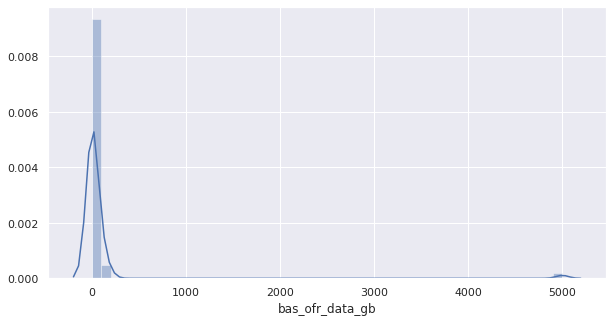

In [37]:
sns.distplot(df_mart06.sample(n=100000).bas_ofr_data_gb)

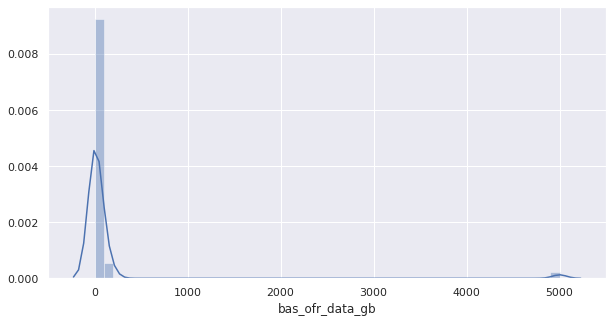

In [38]:
sns.distplot(df_mart07.sample(n=100000).bas_ofr_data_gb)

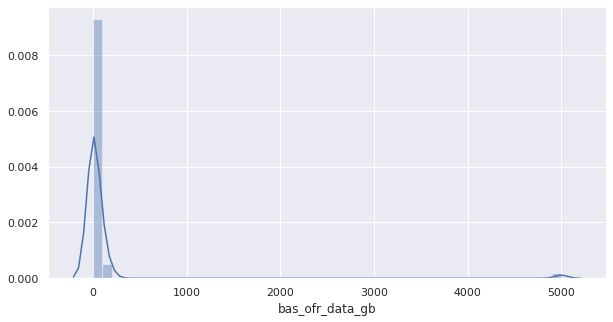

In [40]:
sns.distplot(df_mart06_new.sample(n=100000).bas_ofr_data_gb)

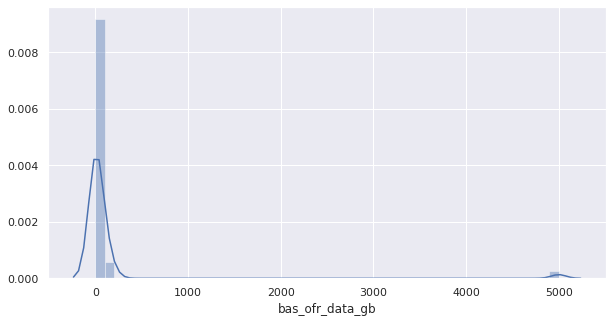

In [39]:
sns.distplot(df_mart07_new.sample(n=100000).bas_ofr_data_gb)

## 8월 데이터를 이용해서 prediction

In [23]:
df_mart08 = pd.read_pickle('/home/dmig/work/upsell/data/df_input_201908.pkl')
df_mart08.shape

(18931654, 80)

In [26]:
df_score = df_mart08[['svc_mgmt_num']]

In [27]:
df_score['score'] = clf.predict(df_mart08[feature_cols])

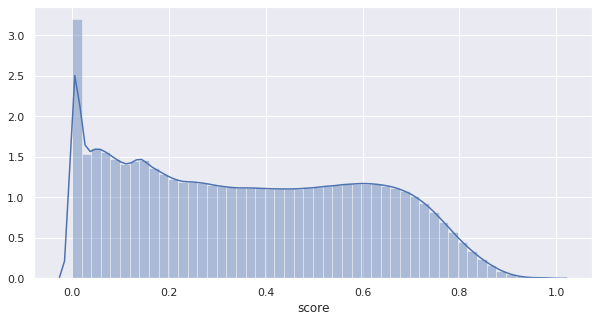

In [28]:
import seaborn as sns

sns.distplot(df_score['score'])

In [29]:
df_score['prod_id'] = 'RC00000001'
df_score['prod_nm'] = '요금제업셀가망'
df_score['score'] = np.round(df_score.score, 4)
df_score['reco_type'] = 'upsell'
df_score['model'] = 'dominic_lgbm_20190709'
df_score['dt'] = '20190905'

In [65]:
df_score.sort_values('score').head(20)

svc_mgmt_num  score     prod_id  prod_nm reco_type  \
2834    7040712978    0.0  RC00000001  요금제업셀가망    upsell   
78463   7035250518    0.0  RC00000001  요금제업셀가망    upsell   
46353   7248941857    0.0  RC00000001  요금제업셀가망    upsell   
60147   7051372031    0.0  RC00000001  요금제업셀가망    upsell   
8740    7248178084    0.0  RC00000001  요금제업셀가망    upsell   
97226   7043736382    0.0  RC00000001  요금제업셀가망    upsell   
2803    7041171364    0.0  RC00000001  요금제업셀가망    upsell   
41696   7190348893    0.0  RC00000001  요금제업셀가망    upsell   
27361   7248875467    0.0  RC00000001  요금제업셀가망    upsell   
79812   7227174688    0.0  RC00000001  요금제업셀가망    upsell   
45006   7235453640    0.0  RC00000001  요금제업셀가망    upsell   
62548   7229887426    0.0  RC00000001  요금제업셀가망    upsell   
96798   7048677718    0.0  RC00000001  요금제업셀가망    upsell   
8635    7248146588    0.0  RC00000001  요금제업셀가망    upsell   
76968   7030674782    0.0  RC00000001  요금제업셀가망    upsell   
38683   1623370110    0.0  RC00000001  요금제업셀가망    upsell   
97714   7215633309    0.0  RC00000001  요금제업셀가망    upsell   
64057   7245564564    0.0  RC00000001  요금제업셀가망    upsell   
4420    7210947915    0.0  RC00000001  요금제업셀가망    upsell   
2973    7042768785    0.0  RC00000001  요금제업셀가망    upsell   

                       model        dt  
2834   dominic_lgbm_20190709  20190905  
78463  dominic_lgbm_20190709  20190905  
46353  dominic_lgbm_20190709  20190905  
60147  dominic_lgbm_20190709  20190905  
8740   dominic_lgbm_20190709  20190905  
97226  dominic_lgbm_20190709  20190905  
2803   dominic_lgbm_20190709  20190905  
41696  dominic_lgbm_20190709  20190905  
27361  dominic_lgbm_20190709  20190905  
79812  dominic_lgbm_20190709  20190905  
45006  dominic_lgbm_20190709  20190905  
62548  dominic_lgbm_20190709  20190905  
96798  dominic_lgbm_20190709  20190905  
8635   dominic_lgbm_20190709  20190905  
76968  dominic_lgbm_20190709  20190905  
38683  dominic_lgbm_20190709  20190905  
97714  dominic_lgbm_20190709  20190905  
64057  dominic_lgbm_20190709  20190905  
4420   dominic_lgbm_20190709  20190905  
2973   dominic_lgbm_20190709  20190905

In [ ]:
conn = hive_connection('dmig')
load_to_hive(conn, 
             df_score[['svc_mgmt_num', 'prod_id', 'prod_nm', 'score', 'reco_type', 'model', 'dt']], 
             'comm.item_reco_predict')

In [ ]:
save_model(clf, 'dominic_lgbm_20190709')

## superset 사용해보기

### load model

In [5]:
input_ym = '201906'
label_ym = next_month(input_ym)

input_sql = "select * from comm.user_profile_pivot_monthly where ym='{}'".format(input_ym)
label_sql = "select * from comm.user_label_matrix_for_upsell_monthly where ym='{}'".format(label_ym)

print(input_sql)
print(label_sql)

select * from comm.user_profile_pivot_monthly where ym='201906'
select * from comm.user_label_matrix_for_upsell_monthly where ym='201907'


In [6]:
conn = hive_connection('dmig')
df_input = load_from_hive(conn, input_sql)
df_input.head()

2019-09-05 14:26:09,588 - YE_HIVE - INFO - ...tmp_db name = tmp_20190905_14_26_09_a482bce2609b95ca350cb4a843cd1964d05701ec
2019-09-05 14:26:09,590 - YE_HIVE - INFO - Start creating table
2019-09-05 14:26:09,591 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190905_14_26_09_a482bce2609b95ca350cb4a843cd1964d05701ec
2019-09-05 14:26:09,642 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190905_14_26_09_a482bce2609b95ca350cb4a843cd1964d05701ec' is done
2019-09-05 14:29:28,456 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190905_14_26_09_a482bce2609b95ca350cb4a843cd1964d05701ec 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from comm.user_profile_pivot_monthly where ym='201906'' is done
2019-09-05 14:29:28,714 - YE_HIVE - INFO - Elapsed Time = 199.12
2019-09-05 14:29:28,716 

svc_mgmt_num sex_cd     age  real_avg_arpu  roaming_cnt_m3  \
0   7290553383      2     9.0        13207.8             0.0   
1   7290553679      B -7981.0        15000.0             0.0   
2   7290554605      1    65.0        25000.0             0.0   
3   7290554629      1    66.0        42000.0             0.0   
4   7290554830      2    39.0            0.0             0.0   

   last_eqp_buy_duration  tw_visit_days_fee_t_small  \
0                    0.0                        0.0   
1                    0.0                        0.0   
2                    0.0                        0.0   
3                    0.0                        0.0   
4                    0.0                        0.0   

   location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
0                          2.0                                 0.0   
1                          0.0                                 0.0   
2                         13.0                                 0.0   
3                         37.0                                 0.0   
4                          7.0                                 0.0   

   app_use_traffic_movie  ...  voc_snd_cnt_student  voc_snd_cnt_interior  \
0                    0.0  ...                  0.0                   0.0   
1                    0.0  ...                  0.0                   0.0   
2                    0.0  ...                  0.0                   0.0   
3                    0.0  ...                  0.0                   0.0   
4                    0.0  ...                  0.0                   0.0   

   voc_rvc_cnt  sms_snd_cnt_wedding  sms_rcv_cnt_interior  sms_snd_cnt_travel  \
0          0.0                  0.0                   0.0                 0.0   
1          0.0                  0.0                   0.0                 0.0   
2          0.0                  0.0                   0.0                 0.0   
3          0.0                  0.0                   0.0                 0.0   
4          0.0                  0.0                   0.0                 0.0   

  mbr_discount_cnt_insurance  voc_rcv_cnt_tax sms_snd_cnt_baby      ym  
0                        0.0              0.0              0.0  201906  
1                        0.0              0.0              0.0  201906  
2                        0.0              0.0              0.0  201906  
3                        0.0              0.0              0.0  201906  
4                        0.0              0.0              0.0  201906  

[5 rows x 415 columns]

In [7]:
df_label = load_from_hive(conn, label_sql)
df_label.head()

2019-09-05 14:39:05,907 - YE_HIVE - INFO - ...tmp_db name = tmp_20190905_14_39_05_d05f25fc9d763216958efae29ab06c99e4bf7ab1
2019-09-05 14:39:05,910 - YE_HIVE - INFO - Start creating table
2019-09-05 14:39:05,911 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190905_14_39_05_d05f25fc9d763216958efae29ab06c99e4bf7ab1
2019-09-05 14:39:05,965 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190905_14_39_05_d05f25fc9d763216958efae29ab06c99e4bf7ab1' is done
2019-09-05 14:41:12,684 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190905_14_39_05_d05f25fc9d763216958efae29ab06c99e4bf7ab1 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from comm.user_label_matrix_for_upsell_monthly where ym='201907'' is done
2019-09-05 14:41:12,930 - YE_HIVE - INFO - Elapsed Time = 127.02
2019-09-05 14:

svc_mgmt_num label af_channel training_yn      ym
0   7304969491     N       오프라인           N  201907
1   7304967554     N       오프라인           N  201907
2   7304965004     N       오프라인           N  201907
3   7304964646     N       오프라인           N  201907
4   7304964005     N       오프라인           N  201907

In [8]:
df_input.shape, df_label.shape

((19323068, 415), (19336764, 5))

In [9]:
df_mart = pd.merge(df_input, df_label[['svc_mgmt_num', 'label']], how='left', on='svc_mgmt_num')

df_mart.shape

(19323068, 416)

In [10]:
del df_input, df_label

In [11]:
import gc
gc.collect()

13225

In [12]:
df_mart.select_dtypes(include=['object']).columns

Index(['svc_mgmt_num', 'sex_cd', 'eqp_mdl_cd',
       'additional_svc_oksusu_scrb_type', 'fee_prod_id',
       'data_gift_recv_yn_bf_m2', 'filter_sex', 'copn_data_u1_yn_bf_m0',
       'svc_scrb_dt', 'channel', 'filter_svc_cd', 'fee_chg_dt',
       'filter_block_obj_cl_cd', 'rmk_omd_yn', 'op_sale_chnl_cl_cd',
       'cncl_aply_bf_equip_chg_dt', 'smartwatch_yn', 'filter_fee_prod',
       'cncl_aply_last_equip_chg_dt', 'additional_svc_allcare_scrb_type',
       'prod_nm', 'additional_svc_ansim_option_scrb_type', 'nh00000059_yn',
       'data_gift_send_yn_bf_m0', 'filter_pps', 'job_cd', 'filter_smile',
       'copn_data_u1_yn_bf_m1', 'filter_svc_st_cd', 'filter_sktemployee',
       'childwatch_yn', 'family_marriage_yn', 'nm_cust_num', 'filter_term_dt',
       'filter_svc_use_typ_cd', 'mbr_card_gr_cd', 'tablet_yn', 'filter_lte',
       'additional_svc_flo_scrb_type', 'na00002040_yn', 'filter_agree_201',
       'svc_gr_cd', 'family_yn', 'filter_tfamilymoa', 'nh00000037_yn',
       'filter_us

In [13]:
# null check
col_null_sum = df_mart.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  label    9283
dtype: int64


In [14]:
df_mart = df_mart[df_mart.label.notnull()]

In [15]:
df_mart.shape

(19313785, 416)

In [ ]:
# TODO: 나중에 zero check
# for col in df_mart.select_dtypes(include=['int', 'float']).columns:
#     zero_rate = df_mart[df_mart[col]==0].shape[0] /df_mart.shape[0]
#     if zero_rate > 0.95:
#         print('-'*20)
#         print('col: ', col)
#         print('zero_rate: ',zero_rate)
#         print('')

In [16]:
# only one value check
for col in df_mart.select_dtypes(include=['int', 'float']).columns:
    if df_mart[col].nunique() == 1:
        print('-'*20)
        print('col: ', col)
        print('value: ', df_mart[col].unique())
        print('')

--------------------
col:  eqp_out_prc
value:  [0.]

--------------------
col:  card_pay_cnt_bf_m1
value:  [0.]

--------------------
col:  voc_rvc_cnt
value:  [0.]



In [17]:
df_mart.drop(['eqp_out_prc', 'card_pay_cnt_bf_m1', 'voc_rvc_cnt'], axis=1, inplace=True)

In [19]:
filter_cols = [c for c in df_mart.columns if 'filter_' in c]
yn_cols = [ c for c in df_mart.columns if 'yn' in c]
dt_cols = [c for c in df_mart.columns if '_dt' in c]

In [22]:
dt_cols

['svc_scrb_dt',
 'fee_chg_dt',
 'cncl_aply_bf_equip_chg_dt',
 'cncl_aply_last_equip_chg_dt',
 'filter_term_dt',
 'scrb_sta_dt',
 'cust_birth_dt']

In [23]:
del_cols = ['rmk_omd_yn', 'sec_dev_yn', 't_agr_t_eqpal_scrb_yn']
del_cols += ['filter_svc_cd', 'filter_sktemployee', 'filter_term_dt', 'filter_agree_201', 'filter_agree_203', 'filter_five_g']
del_cols += ['scrb_sta_dt', 'cust_birth_dt', 'cncl_aply_bf_equip_chg_dt']
df_mart.drop(del_cols, axis=1, inplace=True)
df_mart = df_mart[df_mart['fee_chg_dt'] != 'N/A'] 

In [24]:
dt_cols = [c for c in df_mart.columns if '_dt' in c]
dt_cols

['svc_scrb_dt', 'fee_chg_dt', 'cncl_aply_last_equip_chg_dt']

In [26]:
for c in dt_cols:
    print('c: ', c)
    new_c = 'days_from_{}'.format(c)
    df_mart[c] = df_mart[c].apply(lambda x: '2020-09-02' if x == '99991231' else x)
    df_mart['delta'] = datetime.now() - pd.to_datetime(df_mart[c])
    df_mart[new_c] = df_mart['delta'].apply(lambda x: x.days)

c:  svc_scrb_dt
c:  fee_chg_dt
c:  cncl_aply_last_equip_chg_dt


In [27]:
df_mart.drop(['delta', 'svc_scrb_dt', 'fee_chg_dt', 'cncl_aply_last_equip_chg_dt'], axis=1, inplace=True)

In [28]:
filter_cols = [c for c in df_mart.columns if 'filter_' in c]
yn_cols = [ c for c in df_mart.columns if 'yn' in c]
dt_cols = [c for c in df_mart.columns if '_dt' in c]

In [29]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [30]:
cat_cols = list(df_mart.select_dtypes(include=['object']).columns)

In [31]:
cat_cols.remove('svc_mgmt_num')
cat_cols.remove('ym')

In [32]:
# label encodinng
d = defaultdict(LabelEncoder)
df_mart[cat_cols] = df_mart[cat_cols].apply(lambda x: d[x.name].fit_transform(x))

In [33]:
df_mart.to_pickle(os.path.join(DATA_PATH, 'df_mart_superset_201906.pkl'))

In [6]:
df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_superset_201906.pkl'))

In [7]:
idx_col = 'svc_mgmt_num'

In [ ]:
df_mart_new = df_mart[~df_mart['svc_mgmt_num'].isin(filter06)]

In [ ]:
# make train data
result = make_train_data(df_mart)

trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']

val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

feature_cols = list(x_trn.columns)

lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

make_train_data +++


In [ ]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'num_threads': 40,
}

In [ ]:
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=5000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)